# Fully Convolutional Networks for Change Detection

Example code for training the network presented in the paper:

```
Daudt, R.C., Le Saux, B. and Boulch, A., 2018, October. Fully convolutional siamese networks for change detection. In 2018 25th IEEE International Conference on Image Processing (ICIP) (pp. 4063-4067). IEEE.
```

Code uses the OSCD dataset:

```
Daudt, R.C., Le Saux, B., Boulch, A. and Gousseau, Y., 2018, July. Urban change detection for multispectral earth observation using convolutional neural networks. In IGARSS 2018-2018 IEEE International Geoscience and Remote Sensing Symposium (pp. 2115-2118). IEEE.
```


FresUNet architecture from paper:

```
Daudt, R.C., Le Saux, B., Boulch, A. and Gousseau, Y., 2019. Multitask learning for large-scale semantic change detection. Computer Vision and Image Understanding, 187, p.102783.
```

Please consider all relevant papers if you use this code.

In [ ]:
# Rodrigo Daudt
# rcdaudt.github.io
# rodrigo.daudt@onera.fr

In [ ]:
! git clone https://github.com/rcdaudt/fully_convolutional_change_detection.git

Cloning into 'fully_convolutional_change_detection'...
remote: Enumerating objects: 17, done.
remote: Total 17 (delta 0), reused 0 (delta 0), pack-reused 17
Receiving objects: 100% (17/17), 12.27 KiB | 1.23 MiB/s, done.
Resolving deltas: 100% (5/5), done.


In [ ]:
#!rm -rf fully_convolutional_change_detection

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/MVA/IA_env/src

/content/drive/MyDrive/MVA/IA_env/src


In [ ]:
# Imports

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torchvision.transforms as tr

# Models
from unet import Unet
from siamunet_conc import SiamUnet_conc
from siamunet_diff import SiamUnet_diff
from fresunet import FresUNet

# Other
import os
import numpy as np
import random
from skimage import io
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm as tqdm
from pandas import read_csv
from math import floor, ceil, sqrt, exp
from IPython import display
import time
from itertools import chain
import time
import warnings
from pprint import pprint



print('IMPORTS OK')


IMPORTS OK


In [ ]:
# Global Variables' Definitions

# PATH_TO_DATASET = './OSCD/'
PATH_TO_DATASET = '../data/images/'
IS_PROTOTYPE = False

FP_MODIFIER = 10 # Tuning parameter, use 1 if unsure

BATCH_SIZE = 32
PATCH_SIDE = 96
N_EPOCHS = 10

NORMALISE_IMGS = True

TRAIN_STRIDE = int(PATCH_SIDE/2) - 1

TYPE = 3 # 0-RGB | 1-RGBIr | 2-All bands s.t. resulution <= 20m | 3-All bands

LOAD_TRAINED = False

DATA_AUG = True


print('DEFINITIONS OK')

DEFINITIONS OK


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [ ]:
# Functions

def adjust_shape(I, s):
    """Adjust shape of grayscale image I to s."""

    # crop if necesary
    I = I[:s[0],:s[1]]
    si = I.shape

    # pad if necessary
    p0 = max(0,s[0] - si[0])
    p1 = max(0,s[1] - si[1])

    return np.pad(I,((0,p0),(0,p1)),'edge')


def read_sentinel_img(path):
    """Read cropped Sentinel-2 image: RGB bands."""
    im_name = os.listdir(path)[0][:-7]
    r = io.imread(path + im_name + "B04.tif")
    g = io.imread(path + im_name + "B03.tif")
    b = io.imread(path + im_name + "B02.tif")

    I = np.stack((r,g,b),axis=2).astype('float')

    if NORMALISE_IMGS:
        I = (I - I.mean()) / I.std()

    return I

def read_sentinel_img_4(path):
    """Read cropped Sentinel-2 image: RGB and NIR bands."""
    im_name = os.listdir(path)[0][:-7]
    r = io.imread(path + im_name + "B04.tif")
    g = io.imread(path + im_name + "B03.tif")
    b = io.imread(path + im_name + "B02.tif")
    nir = io.imread(path + im_name + "B08.tif")

    I = np.stack((r,g,b,nir),axis=2).astype('float')

    if NORMALISE_IMGS:
        I = (I - I.mean()) / I.std()

    return I

def read_sentinel_img_leq20(path):
    """Read cropped Sentinel-2 image: bands with resolution less than or equals to 20m."""
    im_name = os.listdir(path)[0][:-7]

    r = io.imread(path + im_name + "B04.tif")
    s = r.shape
    g = io.imread(path + im_name + "B03.tif")
    b = io.imread(path + im_name + "B02.tif")
    nir = io.imread(path + im_name + "B08.tif")

    ir1 = adjust_shape(zoom(io.imread(path + im_name + "B05.tif"),2),s)
    ir2 = adjust_shape(zoom(io.imread(path + im_name + "B06.tif"),2),s)
    ir3 = adjust_shape(zoom(io.imread(path + im_name + "B07.tif"),2),s)
    nir2 = adjust_shape(zoom(io.imread(path + im_name + "B8A.tif"),2),s)
    swir2 = adjust_shape(zoom(io.imread(path + im_name + "B11.tif"),2),s)
    swir3 = adjust_shape(zoom(io.imread(path + im_name + "B12.tif"),2),s)

    I = np.stack((r,g,b,nir,ir1,ir2,ir3,nir2,swir2,swir3),axis=2).astype('float')

    if NORMALISE_IMGS:
        I = (I - I.mean()) / I.std()

    return I

def read_sentinel_img_leq60(path):
    """Read cropped Sentinel-2 image: all bands."""
    im_name = os.listdir(path)[0][:-7]

    r = io.imread(path + im_name + "B04.tif")
    s = r.shape
    g = io.imread(path + im_name + "B03.tif")
    b = io.imread(path + im_name + "B02.tif")
    nir = io.imread(path + im_name + "B08.tif")

    ir1 = adjust_shape(zoom(io.imread(path + im_name + "B05.tif"),2),s)
    ir2 = adjust_shape(zoom(io.imread(path + im_name + "B06.tif"),2),s)
    ir3 = adjust_shape(zoom(io.imread(path + im_name + "B07.tif"),2),s)
    nir2 = adjust_shape(zoom(io.imread(path + im_name + "B8A.tif"),2),s)
    swir2 = adjust_shape(zoom(io.imread(path + im_name + "B11.tif"),2),s)
    swir3 = adjust_shape(zoom(io.imread(path + im_name + "B12.tif"),2),s)

    uv = adjust_shape(zoom(io.imread(path + im_name + "B01.tif"),6),s)
    wv = adjust_shape(zoom(io.imread(path + im_name + "B09.tif"),6),s)
    swirc = adjust_shape(zoom(io.imread(path + im_name + "B10.tif"),6),s)

    I = np.stack((r,g,b,nir,ir1,ir2,ir3,nir2,swir2,swir3,uv,wv,swirc),axis=2).astype('float')

    if NORMALISE_IMGS:
        I = (I - I.mean()) / I.std()

    return I

def read_sentinel_img_trio(path):
    """Read cropped Sentinel-2 image pair and change map."""
#     read images
    if TYPE == 0:
        I1 = read_sentinel_img(path + '/imgs_1/')
        I2 = read_sentinel_img(path + '/imgs_2/')
    elif TYPE == 1:
        I1 = read_sentinel_img_4(path + '/imgs_1/')
        I2 = read_sentinel_img_4(path + '/imgs_2/')
    elif TYPE == 2:
        I1 = read_sentinel_img_leq20(path + '/imgs_1/')
        I2 = read_sentinel_img_leq20(path + '/imgs_2/')
    elif TYPE == 3:
        I1 = read_sentinel_img_leq60(path + '/imgs_1/')
        I2 = read_sentinel_img_leq60(path + '/imgs_2/')

    cm = io.imread(path + '/cm/cm.png', as_gray=True) != 0

    # crop if necessary
    s1 = I1.shape
    s2 = I2.shape
    I2 = np.pad(I2,((0, s1[0] - s2[0]), (0, s1[1] - s2[1]), (0,0)),'edge')


    return I1, I2, cm



def reshape_for_torch(I):
    """Transpose image for PyTorch coordinates."""
#     out = np.swapaxes(I,1,2)
#     out = np.swapaxes(out,0,1)
#     out = out[np.newaxis,:]
    out = I.transpose((2, 0, 1))
    return torch.from_numpy(out)



class ChangeDetectionDataset(Dataset):
    """Change Detection dataset class, used for both training and test data."""

    def __init__(self, path, train = True, patch_side = 96, stride = None, use_all_bands = False, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """

        # basics
        self.transform = transform
        self.path = path
        self.patch_side = patch_side
        if not stride:
            self.stride = 1
        else:
            self.stride = stride

        if train:
            fname = 'train.txt'
        else:
            fname = 'test.txt'

#         print(path + fname)
        self.names = read_csv(path + fname).columns
        self.n_imgs = self.names.shape[0]

        n_pix = 0
        true_pix = 0


        # load images
        self.imgs_1 = {}
        self.imgs_2 = {}
        self.change_maps = {}
        self.n_patches_per_image = {}
        self.n_patches = 0
        self.patch_coords = []
        for im_name in tqdm(self.names):
            # load and store each image
            I1, I2, cm = read_sentinel_img_trio(self.path + im_name)
            self.imgs_1[im_name] = reshape_for_torch(I1)
            self.imgs_2[im_name] = reshape_for_torch(I2)
            self.change_maps[im_name] = cm

            s = cm.shape
            n_pix += np.prod(s)
            true_pix += cm.sum()

            # calculate the number of patches
            s = self.imgs_1[im_name].shape
            n1 = ceil((s[1] - self.patch_side + 1) / self.stride)
            n2 = ceil((s[2] - self.patch_side + 1) / self.stride)
            n_patches_i = n1 * n2
            self.n_patches_per_image[im_name] = n_patches_i
            self.n_patches += n_patches_i

            # generate path coordinates
            for i in range(n1):
                for j in range(n2):
                    # coordinates in (x1, x2, y1, y2)
                    current_patch_coords = (im_name,
                                    [self.stride*i, self.stride*i + self.patch_side, self.stride*j, self.stride*j + self.patch_side],
                                    [self.stride*(i + 1), self.stride*(j + 1)])
                    self.patch_coords.append(current_patch_coords)

        self.weights = [ FP_MODIFIER * 2 * true_pix / n_pix, 2 * (n_pix - true_pix) / n_pix]



    def get_img(self, im_name):
        return self.imgs_1[im_name], self.imgs_2[im_name], self.change_maps[im_name]

    def __len__(self):
        return self.n_patches

    def __getitem__(self, idx):
        current_patch_coords = self.patch_coords[idx]
        im_name = current_patch_coords[0]
        limits = current_patch_coords[1]
        centre = current_patch_coords[2]

        I1 = self.imgs_1[im_name][:, limits[0]:limits[1], limits[2]:limits[3]]
        I2 = self.imgs_2[im_name][:, limits[0]:limits[1], limits[2]:limits[3]]

        label = self.change_maps[im_name][limits[0]:limits[1], limits[2]:limits[3]]
        label = torch.from_numpy(1*np.array(label)).float()

        sample = {'I1': I1, 'I2': I2, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample



class RandomFlip(object):
    """Flip randomly the images in a sample."""

#     def __init__(self):
#         return

    def __call__(self, sample):
        I1, I2, label = sample['I1'], sample['I2'], sample['label']

        if random.random() > 0.5:
            I1 =  I1.numpy()[:,:,::-1].copy()
            I1 = torch.from_numpy(I1)
            I2 =  I2.numpy()[:,:,::-1].copy()
            I2 = torch.from_numpy(I2)
            label =  label.numpy()[:,::-1].copy()
            label = torch.from_numpy(label)

        return {'I1': I1, 'I2': I2, 'label': label}



class RandomRot(object):
    """Rotate randomly the images in a sample."""

#     def __init__(self):
#         return

    def __call__(self, sample):
        I1, I2, label = sample['I1'], sample['I2'], sample['label']

        n = random.randint(0, 3)
        if n:
            I1 =  sample['I1'].numpy()
            I1 = np.rot90(I1, n, axes=(1, 2)).copy()
            I1 = torch.from_numpy(I1)
            I2 =  sample['I2'].numpy()
            I2 = np.rot90(I2, n, axes=(1, 2)).copy()
            I2 = torch.from_numpy(I2)
            label =  sample['label'].numpy()
            label = np.rot90(label, n, axes=(0, 1)).copy()
            label = torch.from_numpy(label)

        return {'I1': I1, 'I2': I2, 'label': label}





print('UTILS OK')


UTILS OK


In [ ]:
# Dataset


if DATA_AUG:
    data_transform = tr.Compose([RandomFlip(), RandomRot()])
else:
    data_transform = None




train_dataset = ChangeDetectionDataset(PATH_TO_DATASET, train = True, stride = TRAIN_STRIDE, transform=data_transform)
weights = torch.FloatTensor(train_dataset.weights).to(device)
print(weights)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)

test_dataset = ChangeDetectionDataset(PATH_TO_DATASET, train = False, stride = TRAIN_STRIDE)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True)


print('DATASETS OK')

100%|██████████| 14/14 [02:39<00:00, 11.42s/it]


tensor([0.4595, 1.9540], device='cuda:0')


100%|██████████| 10/10 [01:38<00:00,  9.81s/it]

DATASETS OK


In [ ]:
# print(weights)

In [ ]:
# 0-RGB | 1-RGBIr | 2-All bands s.t. resulution <= 20m | 3-All bands

if TYPE == 0:
#     net, net_name = Unet(2*3, 2), 'FC-EF'
#     net, net_name = SiamUnet_conc(3, 2), 'FC-Siam-conc'
     net, net_name = SiamUnet_diff(3, 2), 'FC-Siam-diff'
#     net, net_name = FresUNet(2*3, 2), 'FresUNet'
elif TYPE == 1:
#     net, net_name = Unet(2*4, 2), 'FC-EF'
#     net, net_name = SiamUnet_conc(4, 2), 'FC-Siam-conc'
     net, net_name = SiamUnet_diff(4, 2), 'FC-Siam-diff'
#    net, net_name = FresUNet(2*4, 2), 'FresUNet'
elif TYPE == 2:
#     net, net_name = Unet(2*10, 2), 'FC-EF'
#     net, net_name = SiamUnet_conc(10, 2), 'FC-Siam-conc'
     net, net_name = SiamUnet_diff(10, 2), 'FC-Siam-diff'
#   net, net_name = FresUNet(2*10, 2), 'FresUNet'
elif TYPE == 3:
#     net, net_name = Unet(2*13, 2), 'FC-EF'
#     net, net_name = SiamUnet_conc(13, 2), 'FC-Siam-conc'
     net, net_name = SiamUnet_diff(13, 2), 'FC-Siam-diff'
#    net, net_name = FresUNet(2*13, 2), 'FresUNet'


net.to(device)

criterion = nn.NLLLoss(weight=weights) # to be used with logsoftmax output

print('NETWORK OK')

NETWORK OK


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Number of trainable parameters:', count_parameters(net))

Number of trainable parameters: 1351586


In [ ]:
# net.load_state_dict(torch.load('net-best_epoch-1_fm-0.7394933126157746.pth.tar'))

def train(n_epochs = N_EPOCHS, save = True):
    t = np.linspace(1, n_epochs, n_epochs)

    epoch_train_loss = 0 * t
    epoch_train_accuracy = 0 * t
    epoch_train_change_accuracy = 0 * t
    epoch_train_nochange_accuracy = 0 * t
    epoch_train_precision = 0 * t
    epoch_train_recall = 0 * t
    epoch_train_Fmeasure = 0 * t
    epoch_test_loss = 0 * t
    epoch_test_accuracy = 0 * t
    epoch_test_change_accuracy = 0 * t
    epoch_test_nochange_accuracy = 0 * t
    epoch_test_precision = 0 * t
    epoch_test_recall = 0 * t
    epoch_test_Fmeasure = 0 * t

#     mean_acc = 0
#     best_mean_acc = 0
    fm = 0
    best_fm = 0

    lss = 1000
    best_lss = 1000

    plt.figure(num=1)
    plt.figure(num=2)
    plt.figure(num=3)


    optimizer = torch.optim.Adam(net.parameters(), weight_decay=1e-4)
#     optimizer = torch.optim.Adam(net.parameters(), lr=0.0005)


    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95)


    for epoch_index in tqdm(range(n_epochs)):
        net.train()
        print('Epoch: ' + str(epoch_index + 1) + ' of ' + str(N_EPOCHS))

        tot_count = 0
        tot_loss = 0
        tot_accurate = 0
        class_correct = list(0. for i in range(2))
        class_total = list(0. for i in range(2))
#         for batch_index, batch in enumerate(tqdm(data_loader)):
        for batch in train_loader:
            I1 = Variable(batch['I1'].float().to(device))
            I2 = Variable(batch['I2'].float().to(device))
            label = torch.squeeze(Variable(batch['label'].to(device)))

            optimizer.zero_grad()
            output = net(I1, I2)
            loss = criterion(output, label.long())
            loss.backward()
            optimizer.step()

        scheduler.step()


        epoch_train_loss[epoch_index], epoch_train_accuracy[epoch_index], cl_acc, pr_rec = test(train_dataset)
        epoch_train_nochange_accuracy[epoch_index] = cl_acc[0]
        epoch_train_change_accuracy[epoch_index] = cl_acc[1]
        epoch_train_precision[epoch_index] = pr_rec[0]
        epoch_train_recall[epoch_index] = pr_rec[1]
        epoch_train_Fmeasure[epoch_index] = pr_rec[2]

#         epoch_test_loss[epoch_index], epoch_test_accuracy[epoch_index], cl_acc, pr_rec = test(test_dataset)
        epoch_test_loss[epoch_index], epoch_test_accuracy[epoch_index], cl_acc, pr_rec = test(test_dataset)
        epoch_test_nochange_accuracy[epoch_index] = cl_acc[0]
        epoch_test_change_accuracy[epoch_index] = cl_acc[1]
        epoch_test_precision[epoch_index] = pr_rec[0]
        epoch_test_recall[epoch_index] = pr_rec[1]
        epoch_test_Fmeasure[epoch_index] = pr_rec[2]

        plt.figure(num=1)
        plt.clf()
        l1_1, = plt.plot(t[:epoch_index + 1], epoch_train_loss[:epoch_index + 1], label='Train loss')
        l1_2, = plt.plot(t[:epoch_index + 1], epoch_test_loss[:epoch_index + 1], label='Test loss')
        plt.legend(handles=[l1_1, l1_2])
        plt.grid()
#         plt.gcf().gca().set_ylim(bottom = 0)
        plt.gcf().gca().set_xlim(left = 0)
        plt.title('Loss')
        display.clear_output(wait=True)
        display.display(plt.gcf())

        plt.figure(num=2)
        plt.clf()
        l2_1, = plt.plot(t[:epoch_index + 1], epoch_train_accuracy[:epoch_index + 1], label='Train accuracy')
        l2_2, = plt.plot(t[:epoch_index + 1], epoch_test_accuracy[:epoch_index + 1], label='Test accuracy')
        plt.legend(handles=[l2_1, l2_2])
        plt.grid()
        plt.gcf().gca().set_ylim(0, 100)
#         plt.gcf().gca().set_ylim(bottom = 0)
#         plt.gcf().gca().set_xlim(left = 0)
        plt.title('Accuracy')
        display.clear_output(wait=True)
        display.display(plt.gcf())

        plt.figure(num=3)
        plt.clf()
        l3_1, = plt.plot(t[:epoch_index + 1], epoch_train_nochange_accuracy[:epoch_index + 1], label='Train accuracy: no change')
        l3_2, = plt.plot(t[:epoch_index + 1], epoch_train_change_accuracy[:epoch_index + 1], label='Train accuracy: change')
        l3_3, = plt.plot(t[:epoch_index + 1], epoch_test_nochange_accuracy[:epoch_index + 1], label='Test accuracy: no change')
        l3_4, = plt.plot(t[:epoch_index + 1], epoch_test_change_accuracy[:epoch_index + 1], label='Test accuracy: change')
        plt.legend(handles=[l3_1, l3_2, l3_3, l3_4])
        plt.grid()
        plt.gcf().gca().set_ylim(0, 100)
#         plt.gcf().gca().set_ylim(bottom = 0)
#         plt.gcf().gca().set_xlim(left = 0)
        plt.title('Accuracy per class')
        display.clear_output(wait=True)
        display.display(plt.gcf())

        plt.figure(num=4)
        plt.clf()
        l4_1, = plt.plot(t[:epoch_index + 1], epoch_train_precision[:epoch_index + 1], label='Train precision')
        l4_2, = plt.plot(t[:epoch_index + 1], epoch_train_recall[:epoch_index + 1], label='Train recall')
        l4_3, = plt.plot(t[:epoch_index + 1], epoch_train_Fmeasure[:epoch_index + 1], label='Train Dice/F1')
        l4_4, = plt.plot(t[:epoch_index + 1], epoch_test_precision[:epoch_index + 1], label='Test precision')
        l4_5, = plt.plot(t[:epoch_index + 1], epoch_test_recall[:epoch_index + 1], label='Test recall')
        l4_6, = plt.plot(t[:epoch_index + 1], epoch_test_Fmeasure[:epoch_index + 1], label='Test Dice/F1')
        plt.legend(handles=[l4_1, l4_2, l4_3, l4_4, l4_5, l4_6])
        plt.grid()
        plt.gcf().gca().set_ylim(0, 1)
#         plt.gcf().gca().set_ylim(bottom = 0)
#         plt.gcf().gca().set_xlim(left = 0)
        plt.title('Precision, Recall and F-measure')
        display.clear_output(wait=True)
        display.display(plt.gcf())


#         mean_acc = (epoch_test_nochange_accuracy[epoch_index] + epoch_test_change_accuracy[epoch_index])/2
#         if mean_acc > best_mean_acc:
#             best_mean_acc = mean_acc
#             save_str = 'net-best_epoch-' + str(epoch_index + 1) + '_acc-' + str(mean_acc) + '.pth.tar'
#             torch.save(net.state_dict(), save_str)


#         fm = pr_rec[2]
        fm = epoch_train_Fmeasure[epoch_index]
        if fm > best_fm:
            best_fm = fm
            save_str = 'net-best_epoch-' + str(epoch_index + 1) + '_fm-' + str(fm) + '.pth.tar'
            torch.save(net.state_dict(), save_str)

        lss = epoch_train_loss[epoch_index]
        if lss < best_lss:
            best_lss = lss
            save_str = 'net-best_epoch-' + str(epoch_index + 1) + '_loss-' + str(lss) + '.pth.tar'
            torch.save(net.state_dict(), save_str)


#         print('Epoch loss: ' + str(tot_loss/tot_count))
        if save:
            im_format = 'png'
    #         im_format = 'eps'

            plt.figure(num=1)
            plt.savefig(net_name + '-01-loss.' + im_format)

            plt.figure(num=2)
            plt.savefig(net_name + '-02-accuracy.' + im_format)

            plt.figure(num=3)
            plt.savefig(net_name + '-03-accuracy-per-class.' + im_format)

            plt.figure(num=4)
            plt.savefig(net_name + '-04-prec-rec-fmeas.' + im_format)

    out = {'train_loss': epoch_train_loss[-1],
           'train_accuracy': epoch_train_accuracy[-1],
           'train_nochange_accuracy': epoch_train_nochange_accuracy[-1],
           'train_change_accuracy': epoch_train_change_accuracy[-1],
           'test_loss': epoch_test_loss[-1],
           'test_accuracy': epoch_test_accuracy[-1],
           'test_nochange_accuracy': epoch_test_nochange_accuracy[-1],
           'test_change_accuracy': epoch_test_change_accuracy[-1]}

    print('pr_c, rec_c, f_meas, pr_nc, rec_nc')
    print(pr_rec)

    return out

L = 1024
N = 2

def test(dset):
    net.eval()
    tot_loss = 0
    tot_count = 0
    tot_accurate = 0

    n = 2
    class_correct = list(0. for i in range(n))
    class_total = list(0. for i in range(n))
    class_accuracy = list(0. for i in range(n))

    tp = 0
    tn = 0
    fp = 0
    fn = 0

    for img_index in dset.names:
        I1_full, I2_full, cm_full = dset.get_img(img_index)

        s = cm_full.shape


        steps0 = np.arange(0,s[0],ceil(s[0]/N))
        steps1 = np.arange(0,s[1],ceil(s[1]/N))
        for ii in range(N):
            for jj in range(N):
                xmin = steps0[ii]
                if ii == N-1:
                    xmax = s[0]
                else:
                    xmax = steps0[ii+1]
                ymin = jj
                if jj == N-1:
                    ymax = s[1]
                else:
                    ymax = steps1[jj+1]
                I1 = I1_full[:, xmin:xmax, ymin:ymax]
                I2 = I2_full[:, xmin:xmax, ymin:ymax]
                cm = cm_full[xmin:xmax, ymin:ymax]

                I1 = Variable(torch.unsqueeze(I1, 0).float()).to(device)
                I2 = Variable(torch.unsqueeze(I2, 0).float()).to(device)
                cm = Variable(torch.unsqueeze(torch.from_numpy(1.0*cm),0).float()).to(device)


                output = net(I1, I2)
                loss = criterion(output, cm.long())
        #         print(loss)
                tot_loss += loss.data * np.prod(cm.size())
                tot_count += np.prod(cm.size())

                _, predicted = torch.max(output.data, 1)

                c = (predicted.int() == cm.data.int())
                for i in range(c.size(1)):
                    for j in range(c.size(2)):
                        l = int(cm.data[0, i, j])
                        class_correct[l] += c[0, i, j]
                        class_total[l] += 1

                pr = (predicted.int() > 0).cpu().numpy()
                gt = (cm.data.int() > 0).cpu().numpy()

                tp += np.logical_and(pr, gt).sum()
                tn += np.logical_and(np.logical_not(pr), np.logical_not(gt)).sum()
                fp += np.logical_and(pr, np.logical_not(gt)).sum()
                fn += np.logical_and(np.logical_not(pr), gt).sum()

    net_loss = tot_loss/tot_count
    net_accuracy = 100 * (tp + tn)/tot_count

    for i in range(n):
        class_accuracy[i] = 100 * class_correct[i] / max(class_total[i],0.00001)

    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    f_meas = 2 * prec * rec / (prec + rec)
    prec_nc = tn / (tn + fn)
    rec_nc = tn / (tn + fp)

    pr_rec = [prec, rec, f_meas, prec_nc, rec_nc]

    return net_loss, net_accuracy, class_accuracy, pr_rec








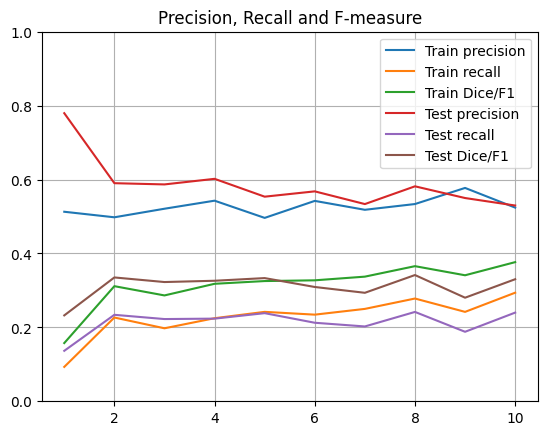

100%|██████████| 10/10 [1:37:36<00:00, 585.63s/it]

pr_c, rec_c, f_meas, pr_nc, rec_nc
[0.5296440774763089, 0.2399184443031592, 0.330243169349436, 0.9615527415529278, 0.9889159724322679]
{'train_loss': 0.1827123463153839, 'train_accuracy': 97.94468724122402, 'train_nochange_accuracy': 99.42414855957031, 'train_change_accuracy': 29.377466201782227, 'test_loss': 0.4014853835105896, 'test_accuracy': 95.18780337773099, 'test_nochange_accuracy': 98.8916015625, 'test_change_accuracy': 23.991844177246094}
Elapsed time:
5856.273111820221


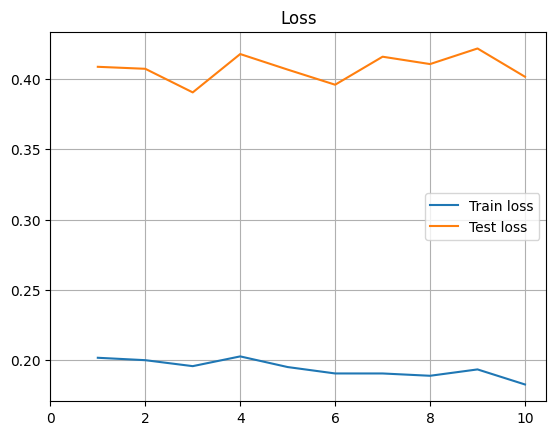

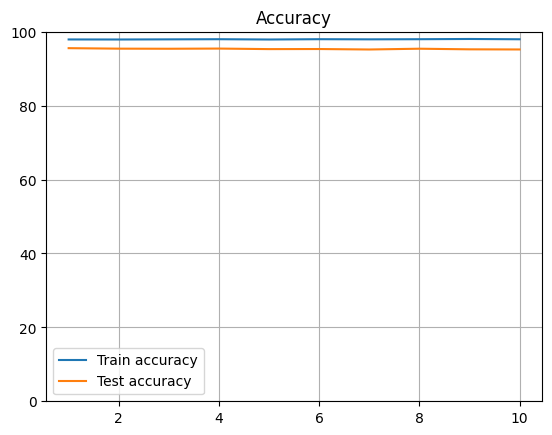

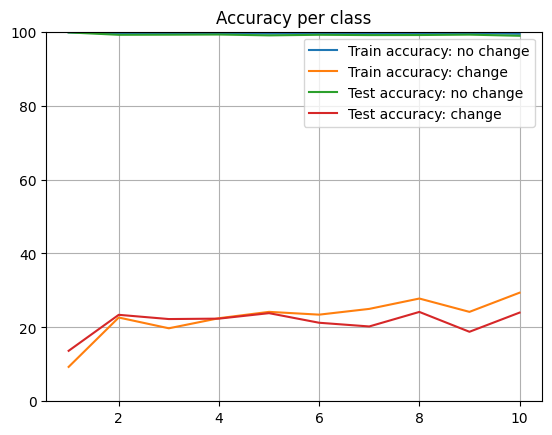

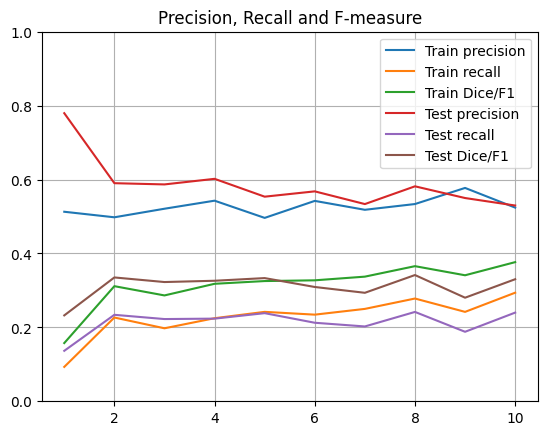

In [ ]:
# DIFF

if LOAD_TRAINED:
    net.load_state_dict(torch.load('net_final.pth.tar'))
    print('LOAD OK')
else:
    t_start = time.time()
    out_dic = train()
    t_end = time.time()
    print(out_dic)
    print('Elapsed time:')
    print(t_end - t_start)




In [ ]:
### DIFF

results = test(test_dataset)
pprint(results)

100%|██████████| 10/10 [01:52<00:00, 11.27s/it]

{'class_accuracy': [98.88800048828125, 22.636022567749023],
 'dice': 0.3160031073994951,
 'kappa': 0.2941988619765766,
 'net_accuracy': 94.98780359374155,
 'net_loss': 0.4218149781227112,
 'precision': 0.5232001028971993,
 'recall': 0.22636023427609522}


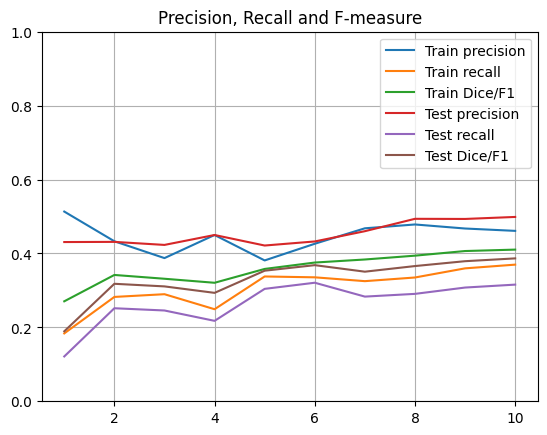

100%|██████████| 10/10 [1:37:51<00:00, 587.16s/it]

pr_c, rec_c, f_meas, pr_nc, rec_nc
[0.49874249132215087, 0.31563370091859777, 0.3866025059210844, 0.9650647828031349, 0.9834971347861731]
{'train_loss': 0.1682412475347519, 'train_accuracy': 97.75600631550304, 'train_nochange_accuracy': 99.06758117675781, 'train_change_accuracy': 36.96963119506836, 'test_loss': 0.3591178357601166, 'test_accuracy': 95.04712782719804, 'test_nochange_accuracy': 98.3497085571289, 'test_change_accuracy': 31.563369750976562}
Elapsed time:
5871.604187011719


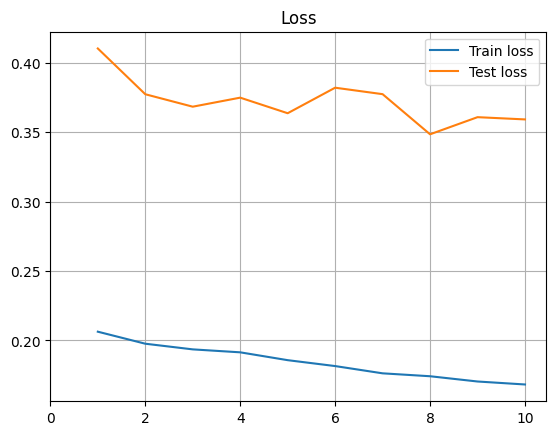

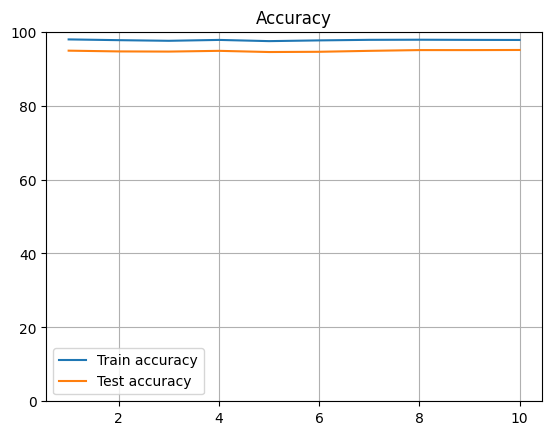

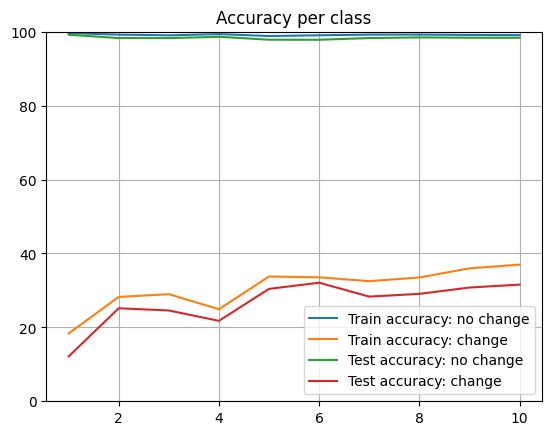

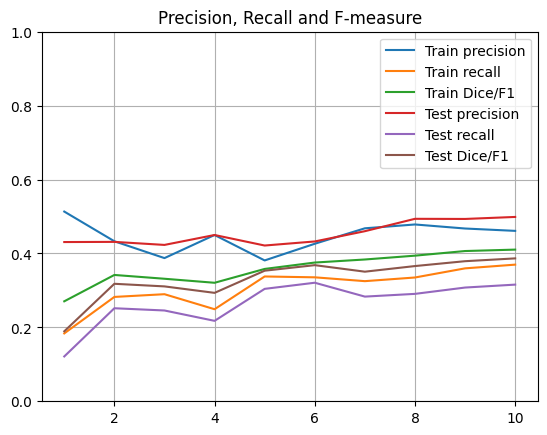

In [ ]:
# CONCAT

# 0-RGB | 1-RGBIr | 2-All bands s.t. resulution <= 20m | 3-All bands

if TYPE == 0:
#     net, net_name = Unet(2*3, 2), 'FC-EF'
     net, net_name = SiamUnet_conc(3, 2), 'FC-Siam-conc'
#    net, net_name = SiamUnet_diff(3, 2), 'FC-Siam-diff'
#     net, net_name = FresUNet(2*3, 2), 'FresUNet'
elif TYPE == 1:
#     net, net_name = Unet(2*4, 2), 'FC-EF'
     net, net_name = SiamUnet_conc(4, 2), 'FC-Siam-conc'
#    net, net_name = SiamUnet_diff(4, 2), 'FC-Siam-diff'
#    net, net_name = FresUNet(2*4, 2), 'FresUNet'
elif TYPE == 2:
#     net, net_name = Unet(2*10, 2), 'FC-EF'
     net, net_name = SiamUnet_conc(10, 2), 'FC-Siam-conc'
#     net, net_name = SiamUnet_diff(10, 2), 'FC-Siam-diff'
#   net, net_name = FresUNet(2*10, 2), 'FresUNet'
elif TYPE == 3:
#     net, net_name = Unet(2*13, 2), 'FC-EF'
     net, net_name = SiamUnet_conc(13, 2), 'FC-Siam-conc'
#    net, net_name = SiamUnet_diff(13, 2), 'FC-Siam-diff'
#    net, net_name = FresUNet(2*13, 2), 'FresUNet'


net.to(device)

criterion = nn.NLLLoss(weight=weights) # to be used with logsoftmax output

print('NETWORK OK')

if LOAD_TRAINED:
    net.load_state_dict(torch.load('net_final.pth.tar'))
    print('LOAD OK')
else:
    t_start = time.time()
    out_dic = train()
    t_end = time.time()
    print(out_dic)
    print('Elapsed time:')
    print(t_end - t_start)

In [ ]:
### CONCAT
results = test(test_dataset)
pprint(results)

100%|██████████| 10/10 [01:54<00:00, 11.47s/it]

{'class_accuracy': [98.40552520751953, 30.1553955078125],
 'dice': 0.37756981671072176,
 'kappa': 0.35281151579667114,
 'net_accuracy': 94.91461804043458,
 'net_loss': 0.37375181913375854,
 'precision': 0.5048267831149927,
 'recall': 0.3015539572348743}


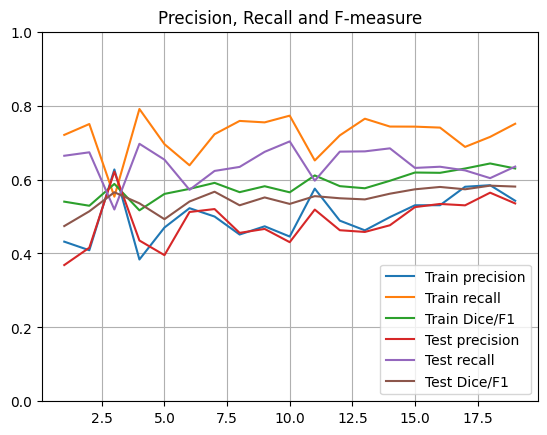

 38%|███▊      | 19/50 [2:58:48<4:50:51, 562.96s/it]

Epoch: 20 of 10


In [ ]:
#FRESNET

net.to(device)

criterion = nn.NLLLoss(weight=weights) # to be used with logsoftmax output

print('NETWORK OK')

if LOAD_TRAINED:
    net.load_state_dict(torch.load('net_final.pth.tar'))
    print('LOAD OK')
else:
    t_start = time.time()
    out_dic = train()
    t_end = time.time()
    print(out_dic)
    print('Elapsed time:')
    print(t_end - t_start)


In [ ]:
if not LOAD_TRAINED:
    torch.save(net.state_dict(), 'cat_net_final_10_epoch.pth.tar')
    print('SAVE OK')

SAVE OK


In [ ]:


def save_test_results(dset):
    for name in tqdm(dset.names):
        with warnings.catch_warnings():
            I1, I2, cm = dset.get_img(name)
            I1 = Variable(torch.unsqueeze(I1, 0).float()).to(device)
            I2 = Variable(torch.unsqueeze(I2, 0).float()).to(device)
            out = net(I1, I2)
            _, predicted = torch.max(out.data, 1)
            I = np.stack((255*cm,255*np.squeeze(predicted.cpu().numpy()),255*cm),2)
            I = I.astype(np.uint8)
            io.imsave(f'{net_name}-{name}.png',I)



t_start = time.time()
# save_test_results(train_dataset)
save_test_results(test_dataset)
t_end = time.time()
print('Elapsed time: {}'.format(t_end - t_start))

100%|██████████| 10/10 [00:00<00:00, 12.67it/s]

Elapsed time: 0.7970716953277588


In [ ]:
L = 1024

def kappa(tp, tn, fp, fn):
    N = tp + tn + fp + fn
    p0 = (tp + tn) / N
    pe = ((tp+fp)*(tp+fn) + (tn+fp)*(tn+fn)) / (N * N)

    return (p0 - pe) / (1 - pe)

def test(dset):
    net.eval()
    tot_loss = 0
    tot_count = 0
    tot_accurate = 0

    n = 2
    class_correct = list(0. for i in range(n))
    class_total = list(0. for i in range(n))
    class_accuracy = list(0. for i in range(n))

    tp = 0
    tn = 0
    fp = 0
    fn = 0

    for img_index in tqdm(dset.names):
        I1_full, I2_full, cm_full = dset.get_img(img_index)

        s = cm_full.shape

        for ii in range(ceil(s[0]/L)):
            for jj in range(ceil(s[1]/L)):
                xmin = L*ii
                xmax = min(L*(ii+1),s[1])
                ymin = L*jj
                ymax = min(L*(jj+1),s[1])
                I1 = I1_full[:, xmin:xmax, ymin:ymax]
                I2 = I2_full[:, xmin:xmax, ymin:ymax]
                cm = cm_full[xmin:xmax, ymin:ymax]

                I1 = Variable(torch.unsqueeze(I1, 0).float()).to(device)
                I2 = Variable(torch.unsqueeze(I2, 0).float()).to(device)
                cm = Variable(torch.unsqueeze(torch.from_numpy(1.0*cm),0).float()).to(device)

                output = net(I1, I2)

                loss = criterion(output, cm.long())
                tot_loss += loss.data * np.prod(cm.size())
                tot_count += np.prod(cm.size())

                _, predicted = torch.max(output.data, 1)

                c = (predicted.int() == cm.data.int())
                for i in range(c.size(1)):
                    for j in range(c.size(2)):
                        l = int(cm.data[0, i, j])
                        class_correct[l] += c[0, i, j]
                        class_total[l] += 1

                pr = (predicted.int() > 0).cpu().numpy()
                gt = (cm.data.int() > 0).cpu().numpy()

                tp += np.logical_and(pr, gt).sum()
                tn += np.logical_and(np.logical_not(pr), np.logical_not(gt)).sum()
                fp += np.logical_and(pr, np.logical_not(gt)).sum()
                fn += np.logical_and(np.logical_not(pr), gt).sum()

    net_loss = tot_loss/tot_count
    net_loss = float(net_loss.cpu().numpy())

    net_accuracy = 100 * (tp + tn)/tot_count

    for i in range(n):
        class_accuracy[i] = 100 * class_correct[i] / max(class_total[i],0.00001)
        class_accuracy[i] =  float(class_accuracy[i].cpu().numpy())

    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    dice = 2 * prec * rec / (prec + rec)
    prec_nc = tn / (tn + fn)
    rec_nc = tn / (tn + fp)

    pr_rec = [prec, rec, dice, prec_nc, rec_nc]

    k = kappa(tp, tn, fp, fn)

    return {'net_loss': net_loss,
            'net_accuracy': net_accuracy,
            'class_accuracy': class_accuracy,
            'precision': prec,
            'recall': rec,
            'dice': dice,
            'kappa': k}